In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def criar_grafo_orientacao(caminho_arquivo):
    try:
        # Carregar os dados do arquivo CSV, especificando a codificação
        df = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1')

        # Selecionar apenas as colunas relevantes e remover linhas com dados faltantes
        colunas_necessarias = ['DiscenteID', 'OrientadorID', 'Unidade', 'Codigo_Projeto']
        df_limpo = df[colunas_necessarias].dropna()

        # Criando uma chave única para cada combinação de DiscenteID, OrientadorID e Codigo_Projeto
        df_limpo['chave_unica'] = df_limpo['DiscenteID'].astype(str) + '_' + df_limpo['OrientadorID'].astype(str) + '_' + df_limpo['Codigo_Projeto'].astype(str)

        # Remover duplicatas com base nesta chave única
        df_processado = df_limpo.drop_duplicates(subset=['chave_unica']).copy()

        # Criar o grafo
        G = nx.Graph()

        # Filtrando Orientadores, Departamentos e Discentes únicos
        orientadores = df_processado['OrientadorID'].unique()
        departamentos = df_processado['Unidade'].unique()
        discentes = df_processado['DiscenteID'].unique()

        # Adicionando os nós ao grafo
        G.add_nodes_from(orientadores, bipartite='orientador')
        G.add_nodes_from(departamentos, bipartite='departamento')
        G.add_nodes_from(discentes, bipartite='discente')

        # Adicionar as ligações (arestas) entre estudantes e orientadores
        for _, row in df_processado.iterrows():
            discente = row['DiscenteID']
            orientador = row['OrientadorID']
            G.add_edge(discente, orientador, tipo='orientacao')

        # Calcular e adicionar arestas entre orientadores e departamentos com peso
        pesos_orientador_departamento = df_processado.groupby(['OrientadorID', 'Unidade']).size().reset_index(name='peso')
        for _, row in pesos_orientador_departamento.iterrows():
            orientador = row['OrientadorID']
            unidade = row['Unidade']
            peso = row['peso']
            G.add_edge(orientador, unidade, peso=peso, tipo='afiliacao')

        # Imprimir informações sobre o grafo
        print(f"Número total de nós: {G.number_of_nodes()}")
        print(f"Número total de arestas: {G.number_of_edges()}")
        print(f"A densidade do grafo: {nx.density(G)}")
        return G

    except FileNotFoundError:
        print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado. Verifique o nome e o caminho do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None

# Exemplo de como usar a função com o seu arquivo
caminho_do_seu_arquivo = "./Iniciação_Ciêntifica - Dados Abertos.csv"
grafo_final = criar_grafo_orientacao(caminho_do_seu_arquivo)

Número total de nós: 28212
Número total de arestas: 33618
A densidade do grafo: 8.447914550950069e-05


Departamentos disponíveis:
1: ESCOLA DE MÚSICA - EMUFRN
2: DEPARTAMENTO DE ENGENHARIA QUIMICA - DEQ/CT
3: CENTRO DE CIÊNCIAS SOCIAIS APLICADAS - CCSA
4: DEPARTAMENTO DE CIÊNCIAS ADMINISTRATIVAS - DEPAD - DEPAD/CCSA
5: DEPARTAMENTO DE ENGENHARIA DE COMUNICAÇÕES - DCO/CT
6: CENTRO DE CIÊNCIAS EXATAS E DA TERRA - CCET
7: DEPARTAMENTO DE ESTATISTICA - EST/CCET
8: ESCOLA AGRÍCOLA DE JUNDIAÍ - EAJ
9: DEPARTAMENTO DE DIREITO PUBLICO - DIPUB - DPU/CCSA
10: DEPARTAMENTO DE FONOAUDIOLOGIA - DEPFONO
11: DEPARTAMENTO DE SAÚDE COLETIVA - DSC/CCS
12: CERES - DEPARTAMENTO DE GEOGRAFIA - DGC/CERES
13: DEPARTAMENTO DE SERVIÇO SOCIAL - DESSO - DESSO/CCSA
14: DEPARTAMENTO DE FUNDAMENTOS E POLÍTICAS DA EDUCAÇÃO - DFPE/CE
15: DEPARTAMENTO DE CIRURGIA - DCIRUR/CCS
16: DEPARTAMENTO DE ANÁLISES CLÍNICAS E TOXICOLÓGICAS - DACT/CCS
17: ESCOLA DE CIÊNCIAS E TECNOLOGIA - ECT
18: DEPARTAMENTO DE PSICOLOGIA - PSIC/CCHLA
19: DEPARTAMENTO DE COMUNICAÇÃO SOCIAL - DECOM/CCHLA
20: DEPARTAMENTO DE GEOGRAFIA/CCHLA - GEO/C

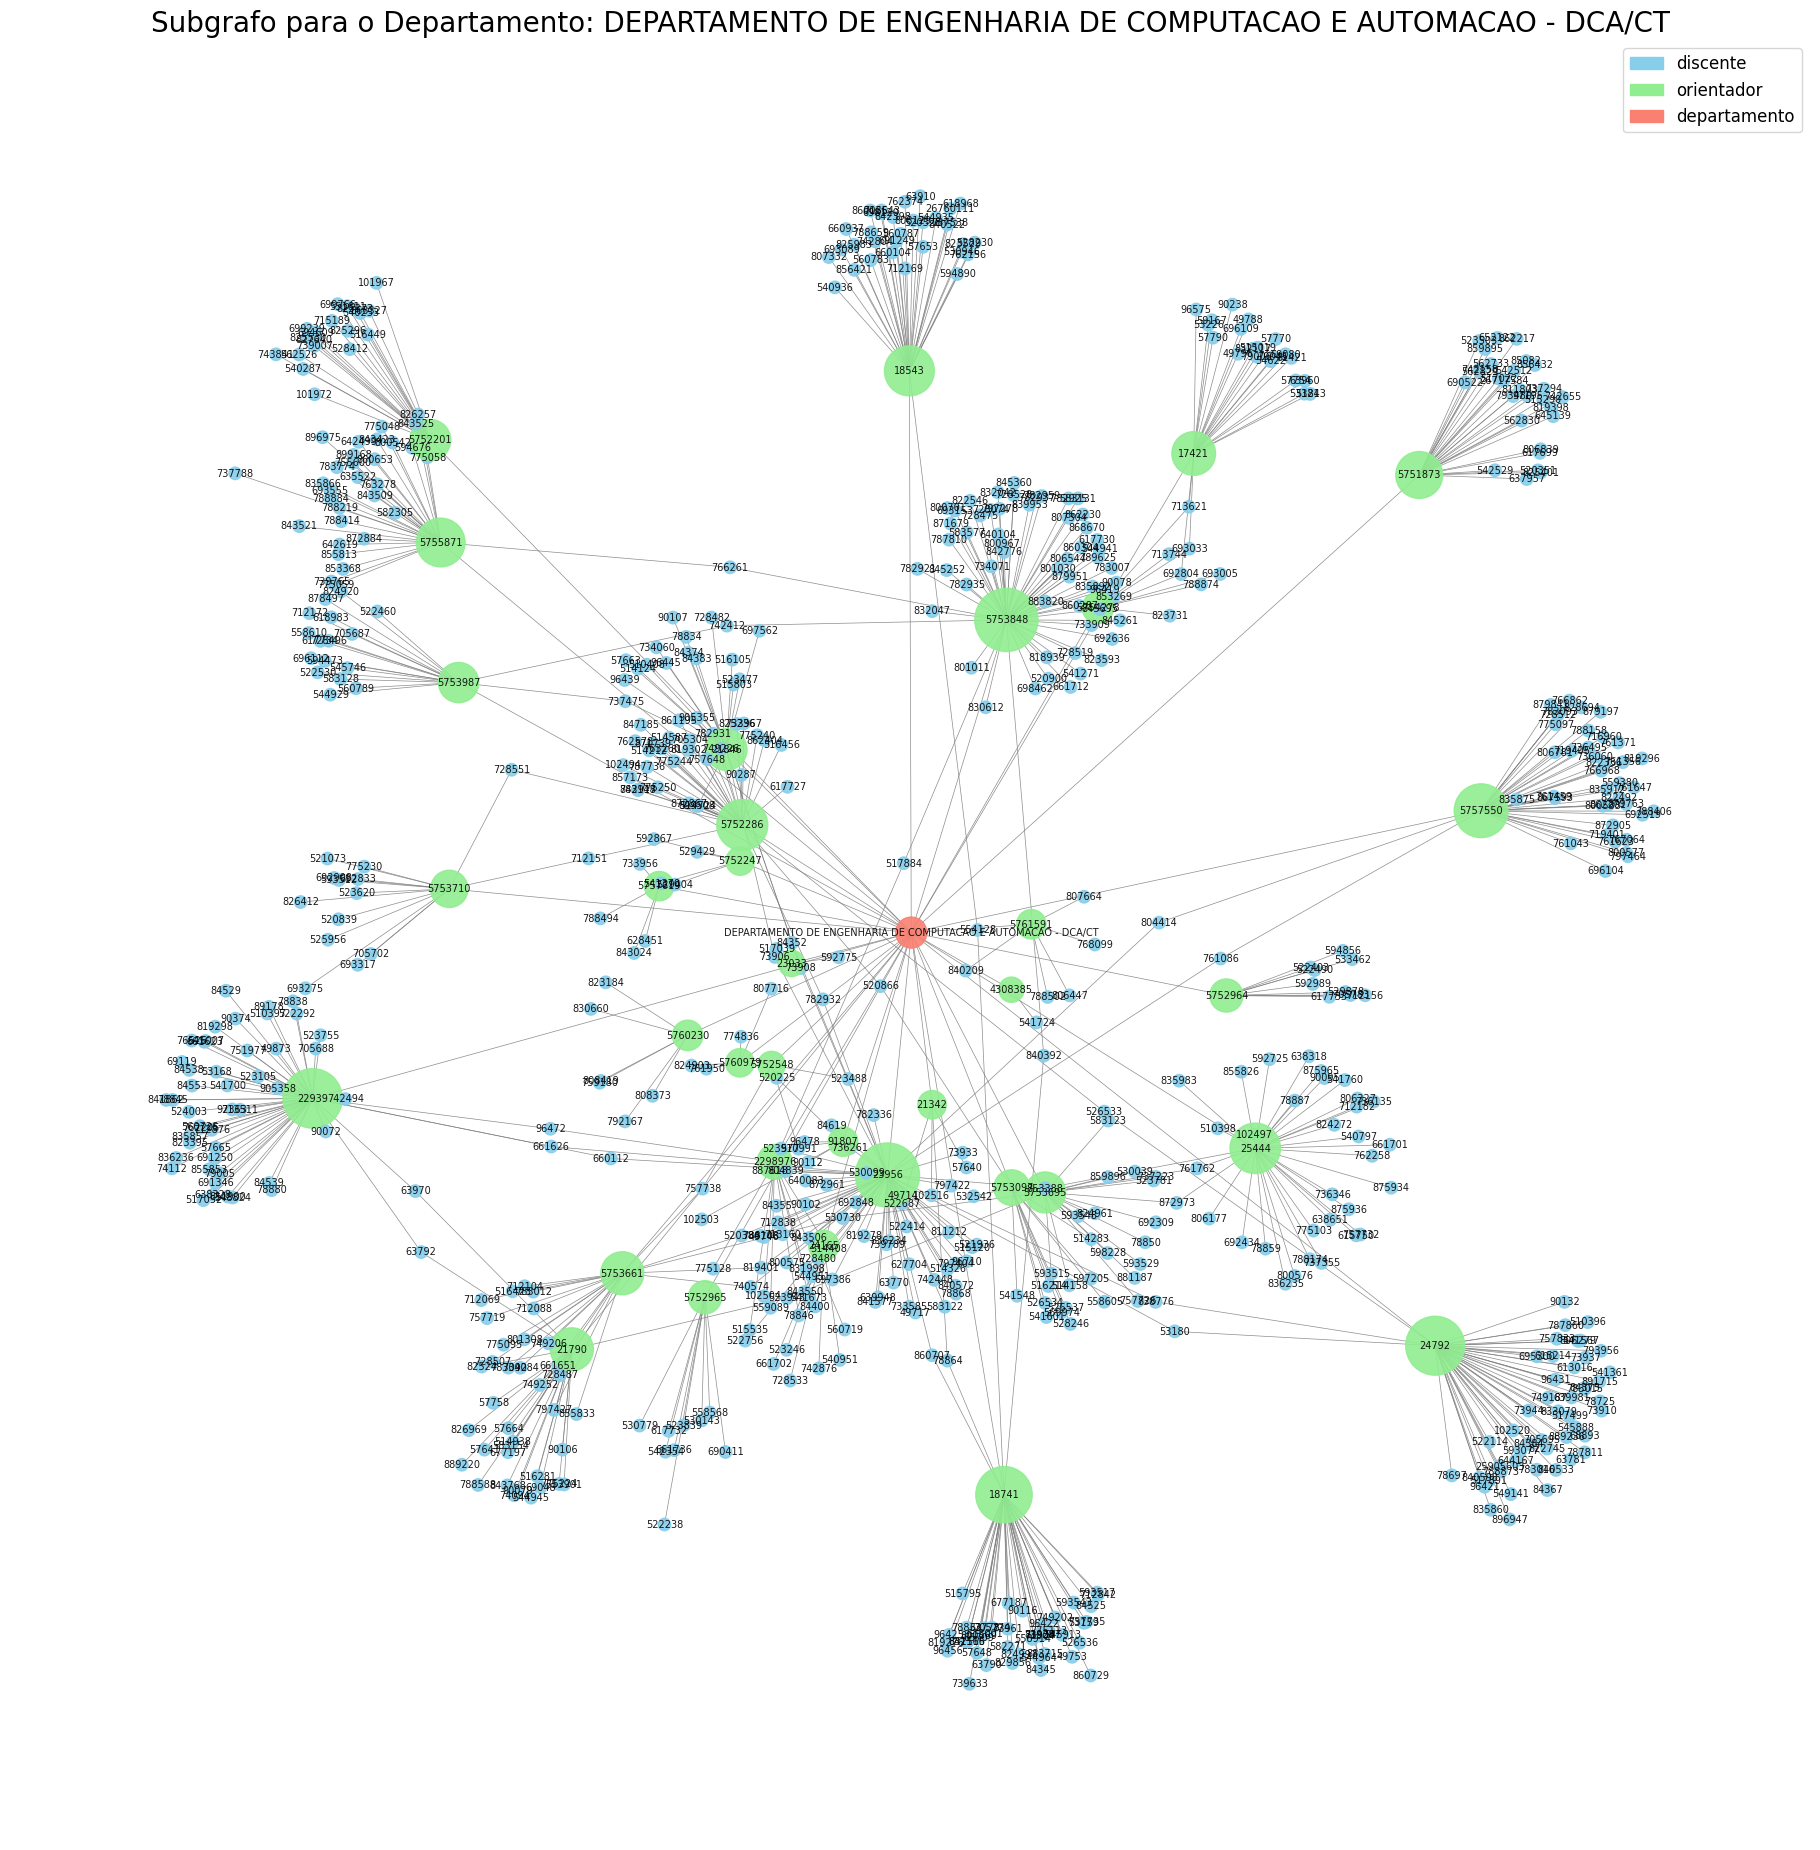

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch # Importar Patch para a legenda

# Obter a lista de departamentos do grafo
departamentos_grafo = [node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'departamento']

# Permitir que o usuário escolha o departamento de interesse
print("Departamentos disponíveis:")
for i, dep in enumerate(departamentos_grafo):
    print(f"{i+1}: {dep}")

escolha = input(f"Digite o número do departamento de interesse (1 a {len(departamentos_grafo)}): ")

try:
    indice_escolhido = int(escolha) - 1
    if 0 <= indice_escolhido < len(departamentos_grafo):
        departamento_interesse = departamentos_grafo[indice_escolhido]
        print(f"Departamento de interesse selecionado: {departamento_interesse}")
    else:
        departamento_interesse = None
        print("Escolha inválida.")
except ValueError:
    departamento_interesse = None
    print("Entrada inválida.")


# Filtrar o subgrafo
if departamento_interesse:
    # Identificar orientadores afiliados com o departamento de interesse
    orientadores_departamento = set()
    for u, v, data in grafo_final.edges(data=True):
        if data.get('tipo') == 'afiliacao' and (u == departamento_interesse or v == departamento_interesse):
            # O outro nó deve ser um orientador
            if grafo_final.nodes[u].get('bipartite') == 'orientador':
                orientadores_departamento.add(u)
            elif grafo_final.nodes[v].get('bipartite') == 'orientador':
                orientadores_departamento.add(v)

    # Identificar discentes orientados por esses orientadores
    discentes_orientados = set()
    for u, v, data in grafo_final.edges(data=True):
        if data.get('tipo') == 'orientacao':
            if u in orientadores_departamento and grafo_final.nodes[v].get('bipartite') == 'discente':
                discentes_orientados.add(v)
            elif v in orientadores_departamento and grafo_final.nodes[u].get('bipartite') == 'discente':
                discentes_orientados.add(u)

    # Criar uma lista de nós para o subgrafo
    nodes_subgrafo = [departamento_interesse] + list(orientadores_departamento) + list(discentes_orientados)

    # Gerar o subgrafo
    subgrafo_departamento = grafo_final.subgraph(nodes_subgrafo).copy() 

    print(f"Número de nós no subgrafo: {subgrafo_departamento.number_of_nodes()}")
    print(f"Número de arestas no subgrafo: {subgrafo_departamento.number_of_edges()}")
    print(f"A densidade do subgrafo: {nx.density(subgrafo_departamento)}")

    # Calcular o número de discentes por orientador no subgrafo
    discentes_por_orientador = {}
    for discente in discentes_orientados:
        for vizinho in subgrafo_departamento.neighbors(discente):
            if subgrafo_departamento.nodes[vizinho].get('bipartite') == 'orientador':
                discentes_por_orientador[vizinho] = discentes_por_orientador.get(vizinho, 0) + 1


    # Visualizar o subgrafo filtrado e Adicionar rótulos e legendas
    # Definir as cores para cada tipo de nó
    cores_mapa = {
        'discente': 'skyblue',
        'orientador': 'lightgreen',
        'departamento': 'salmon'
    }

    # Definir tamanhos dos nós
    tamanhos_nos = []
    for node in subgrafo_departamento.nodes():
        if subgrafo_departamento.nodes[node].get('bipartite') == 'orientador':
            # Aumentar o tamanho do nó do orientador com base no número de discentes
            tamanho = 300 + (discentes_por_orientador.get(node, 0) * 30)
            tamanhos_nos.append(tamanho)
        elif subgrafo_departamento.nodes[node].get('bipartite') == 'discente':
            tamanhos_nos.append(80) # Tamanho ligeiramente maior para discentes
        else:
            tamanhos_nos.append(500) # Tamanho maior para o departamento

    # Obter os tipos de nós do subgrafo e mapear para cores
    node_colors = [cores_mapa.get(subgrafo_departamento.nodes[node].get('bipartite'), 'gray') for node in subgrafo_departamento.nodes()]

    # Aqui podemos brincar um pouco com diferentes layouts! Teste agora mesmo!" 
    pos = nx.spring_layout(subgrafo_departamento, k= 0.7) # Ajuste o parâmetro k para espaçamento
    # pos = nx.kamada_kawai_layout(subgrafo_departamento)
    # pos = nx.random_layout(subgrafo_departamento) # Um layout aleatório para começar
    # pos = nx.circular_layout(subgrafo_departamento)

    # Configurar tamanho da figura
    plt.figure(figsize=(18, 18)) # Aumentar o tamanho da figura

    # Desenhar o grafo com rótulos
    nx.draw(subgrafo_departamento, pos, node_color=node_colors, node_size=tamanhos_nos,
            with_labels=True, font_size=7, alpha=0.9, edge_color='gray', width=0.5) # Ajustar fonte, transparência, cor e largura das arestas

    # Criar patches para a legenda
    legend_patches = [Patch(color=color, label=label) for label, color in cores_mapa.items()]

    # Adicionar a legenda
    plt.legend(handles=legend_patches, loc='best', fontsize=12) # Ajustar tamanho da fonte da legenda

    # Definir o título
    plt.title(f"Subgrafo para o Departamento: {departamento_interesse}", fontsize=20) # Ajustar tamanho da fonte do título

    # Remover eixos
    plt.axis('off')

    # Exibir o plot
    plt.show()
else:
    print("Não foi possível gerar o subgrafo pois o departamento não foi selecionado ou é inválido.")

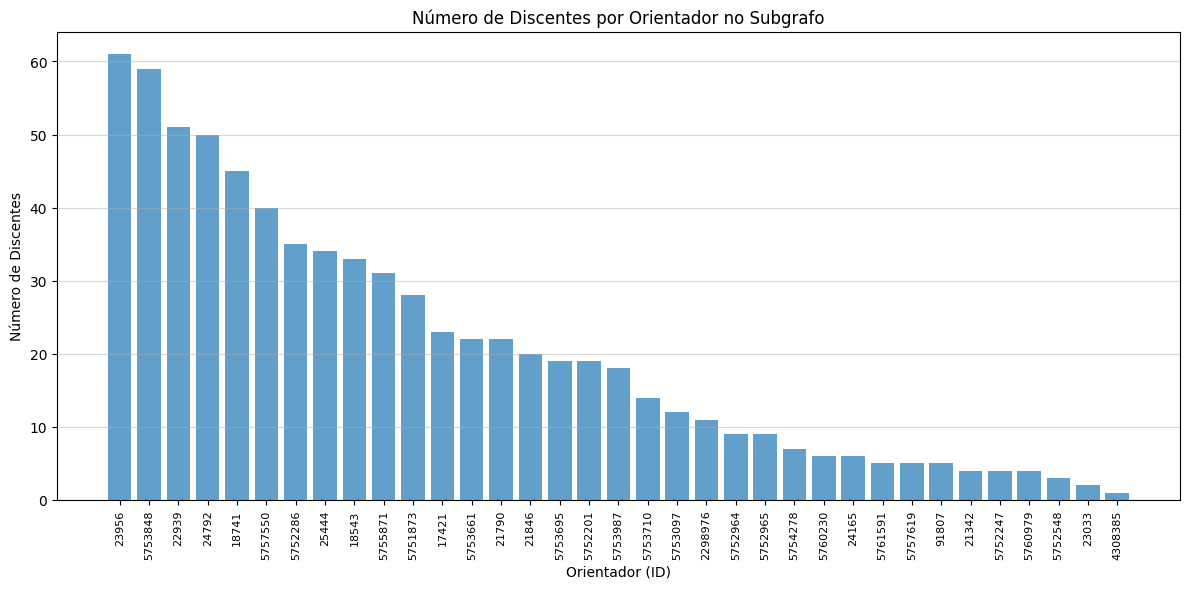

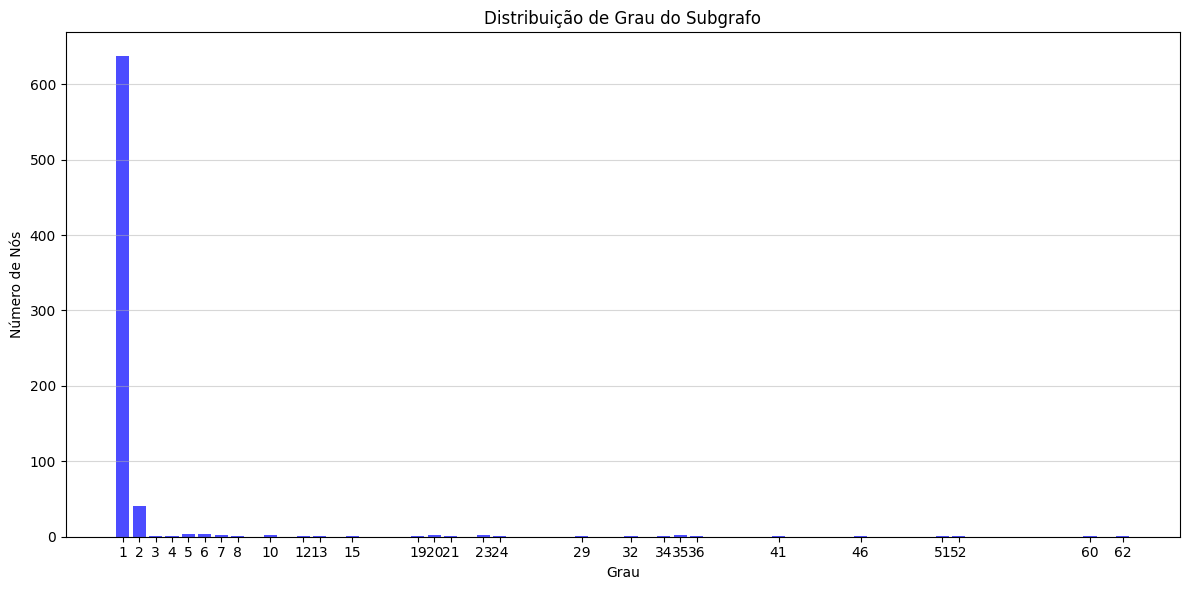

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import collections # Importar collections para contar graus

# Calcular o número de discentes por orientador para o gráfico de barras
discentes_por_orientador = {}
# Certifique-se de iterar sobre os nós do subgrafo que são orientadores
orientadores_no_subgrafo = [node for node, data in subgrafo_departamento.nodes(data=True) if data.get('bipartite') == 'orientador']

for orientador in orientadores_no_subgrafo:
    # Contar discentes conectados a este orientador no subgrafo
    count = 0
    for neighbor in subgrafo_departamento.neighbors(orientador):
        if subgrafo_departamento.nodes[neighbor].get('bipartite') == 'discente':
            count += 1
    discentes_por_orientador[orientador] = count

# Preparar dados para o gráfico de barras
orientadores_ids = list(discentes_por_orientador.keys())
numero_discentes = list(discentes_por_orientador.values())

# Ordenar os orientadores pelo número de discentes para uma melhor visualização no gráfico de barras
orientadores_ordenados, discentes_ordenados = zip(*sorted(zip(orientadores_ids, numero_discentes), key=lambda x: x[1], reverse=True))


# Criar o gráfico de barras (Orientadores x Discentes)
plt.figure(figsize=(12, 6)) # Aumentar o tamanho para acomodar mais barras
plt.bar(range(len(orientadores_ordenados)), discentes_ordenados, alpha=0.7)
plt.xlabel("Orientador (ID)")
plt.ylabel("Número de Discentes")
plt.title("Número de Discentes por Orientador no Subgrafo")
plt.xticks(range(len(orientadores_ordenados)), orientadores_ordenados, rotation=90, fontsize=8) # Rotacionar rótulos do eixo x e diminuir fonte
plt.tight_layout() # Ajustar layout para evitar sobreposição de rótulos
plt.grid(axis='y', alpha=0.5)
plt.show()

# Print de espaçamento
print()

# Calcular a distribuição de grau
degree_sequence = sorted([d for n, d in subgrafo_departamento.degree()], reverse=True)  # sequência de graus
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

# Criar o gráfico de distribuição de grau
fig, ax = plt.subplots(figsize=(12, 6)) # Usar o mesmo tamanho de figura do primeiro gráfico
plt.bar(deg, cnt, width=0.8, color='b', alpha=0.7) # Usar a mesma transparência

plt.title("Distribuição de Grau do Subgrafo")
plt.ylabel("Número de Nós")
plt.xlabel("Grau")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg) # Mostrar todos os graus no eixo x
plt.grid(axis='y', alpha=0.5) # Adicionar grid no eixo y
plt.tight_layout() # Ajustar layout
plt.show()